# Tutorial for Using Split-Raster for Deep Learning

This demo we will split a large image into small tiles. It is useful for deep learning and computer vision tasks. The package can also be used to split a large image into small tiles for other applications.

For example, we have a large image of size 1000-by-1000, and we want to split it into 256-by-256 tiles. The `SplitRaster` package successfully generate 16 256x256 images tiles with automatic padding on the edges. You can adjust the tile size and the overlap of the tiles for your own applications.


Setup your local or cloud environment for this demo.

This demo we use the python 3.10, but the package is compatible with python 3.7, 3.8, 3.9, 3.10, 3.11, 3.12. 

In [1]:
!python --version

Python 3.10.16


In [2]:
! pip install -q splitraster


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Clean the output folder
!rm -rf ../data/processed/RGB
!rm -rf ../data/processed/GT

In [4]:
from splitraster import io

input_image_path = "../data/raw/RGB.png"
gt_image_path = "../data/raw/GT.png"

save_path = "../data/processed/RGB"
save_path_gt = "../data/processed/GT"

crop_size = 256
repetition_rate = 0 # <----- change this value to 0.5 for 50% overlap
overwrite = True # <----- change this value to False for no overwrite demo

n = io.split_image(input_image_path, save_path, crop_size,
                   repetition_rate=repetition_rate, overwrite=overwrite)
print(f"{n} tiles sample of {input_image_path} are added at {save_path}")


n = io.split_image(gt_image_path, save_path_gt, crop_size,
                   repetition_rate=repetition_rate, overwrite=overwrite)
print(f"{n} tiles sample of {gt_image_path} are added at {save_path_gt}")

Input Image File Shape (H, W, D):(1000, 1000, 3)
crop_size = 256, stride = 256
Padding Image File Shape (H, W, D):(1024, 1024, 3)


Generating: 100%|██████████| 16/16 [00:00<00:00, 120.51img/s]


16 tiles sample of ../data/raw/RGB.png are added at ../data/processed/RGB
Input Image File Shape (H, W, D):(1000, 1000)
crop_size = 256, stride = 256
Padding Image File Shape (H, W, D):(1024, 1024)


Generating: 100%|██████████| 16/16 [00:00<00:00, 788.79img/s]

16 tiles sample of ../data/raw/GT.png are added at ../data/processed/GT


## Random Sampling Code

If you want to create a small data set at the early stage for exploaration. Use the random sampling code, you can use the following code. The following code shows to geneate a 20 tiles (256x256) from the 1000x1000 image.

In [5]:
# Clean the output folder
!rm -rf ../data/processed/Rand/RGB
!rm -rf ../data/processed/Rand/GT

In [6]:
from splitraster import io
input_image_path = "../data/raw/RGB.png"
gt_image_path = "../data/raw/GT.png"

input_save_path = "../data/processed/Rand/RGB"  
gt_save_path = "../data/processed/Rand/GT"

n = io.random_crop_image(input_image_path, input_save_path,  gt_image_path, gt_save_path, crop_size=256, crop_number=20, img_ext='.png', label_ext='.png', overwrite=True)

print(f"{n} sample paris of {input_image_path, gt_image_path} are added at {input_save_path, gt_save_path}.")

Generating: 100%|██████████| 20/20 [00:00<00:00, 87.67img/s]

20 sample paris of ('../data/raw/RGB.png', '../data/raw/GT.png') are added at ('../data/processed/Rand/RGB', '../data/processed/Rand/GT').


## Use the output of the Split-Raster as the input of the Deep Learning Model

We will use pytorch as the deep learning framework for this demo.

In [7]:
! pip install -q torch torchvision matplotlib


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


### Create a DataLoader for the Split-Raster output

In [8]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from skimage.io import imread, imsave
import os 
import numpy as np

In [9]:
class DatasetSegmentation(torch.utils.data.Dataset):
    def __init__(self, image_path, label_path):
        self.imgfolder = image_path
        self.maskfolder = label_path
        self.imgs = list(sorted(os.listdir(image_path)))
        self.masks = list(sorted(os.listdir(label_path)))

    def __getitem__(self, idx):
        img_path = os.path.join(self.imgfolder, self.imgs[idx])
        mask_path = os.path.join(self.maskfolder, self.masks[idx])
        data = imread(img_path)
        data = np.moveaxis(data, -1, 0)
        label = imread(mask_path)
        label = label/255
        return torch.from_numpy(data).float(), torch.from_numpy(label).long()

    def __len__(self):
        return len(self.imgs)

In [10]:
AerialDataset = DatasetSegmentation("../data/processed/RGB", "../data/processed/GT")

Create a DataLoader and read a batch of images from the Split-Raster output.
 

In [11]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(AerialDataset, batch_size=16, shuffle=False)
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([16, 3, 256, 256])
Labels batch shape: torch.Size([16, 256, 256])


Visualize the images and labels.

Feature batch shape: ((3, 256, 256), 221.0, 4.0)
Labels batch shape: ((256, 256), 1, 0)


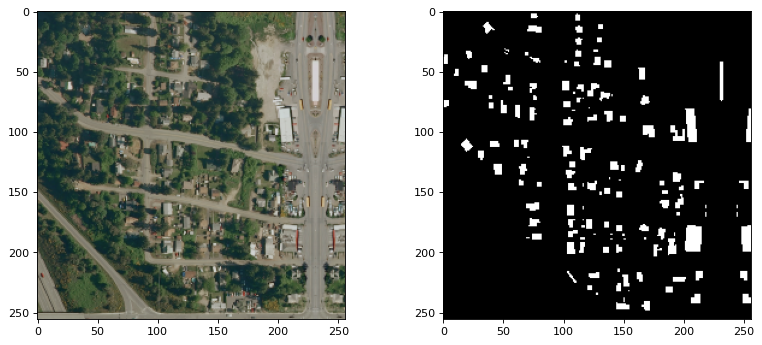

In [12]:
# Select 16 random images from the training set
import random
idx = random.randint(0, 15)
img = train_features[idx].squeeze().numpy()
label = train_labels[idx].squeeze().numpy()

print(f"Feature batch shape: {img.shape, img.max(), img.min()}")
print(f"Labels batch shape: {label.shape, label.max(), label.min()}")



from matplotlib.pyplot import figure

figure(figsize=(12, 5), dpi=80)
plt.subplot(1,2,1)
img = np.moveaxis(img, 0, -1) # adjust the channel dimension
plt.imshow(img.astype(np.uint8) )
plt.subplot(1,2,2)

plt.imshow(label.astype(np.uint8), cmap="gray")
plt.show()

Use torchvision to visualize the images and labels.

In [13]:
import torchvision
grid_img = torchvision.utils.make_grid(train_features/255, nrow=4)
grid_label = torchvision.utils.make_grid(train_labels.unsqueeze_(1), nrow=4)

In [14]:
grid_img.shape, grid_label.shape

(torch.Size([3, 1034, 1034]), torch.Size([3, 1034, 1034]))

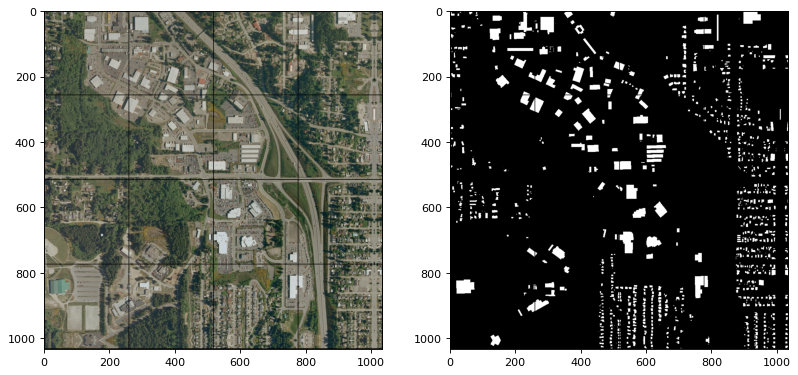

In [15]:
figure(figsize=(12, 18), dpi=80)
plt.subplot(1,2,1)
plt.imshow(grid_img.permute(1, 2, 0))
plt.subplot(1,2,2)
plt.imshow(grid_label[0,:,:], cmap='gray')
plt.show()

With the DataLoader, we can start working on train the deep learning model. 

In [16]:
from datetime import datetime
print(f"Latest run time {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Latest run time 2025-03-23 20:34:29


--- 